In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostRegressor
import optuna
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import RandomForestRegressor


In [4]:
data = pd.read_csv('test-data/2022_dataset.csv')

# Check NaN

- PRE : 강수량 NaN 값 0으로 처리
- RH : 상대습도
- DT : 일조시간

In [5]:
data.isnull().sum()

Date        0
AT          0
MinT        0
MaxT        0
PRE       261
AWS         0
MaxWD       0
MaxIWD      0
MaxWS       0
MaxIWS      0
RH          1
DT         39
CA          0
Result      0
dtype: int64

In [6]:
data[data['PRE'].isnull()]

,Date,AT,MinT,MaxT,PRE,AWS,MaxWD,MaxIWD,MaxWS,MaxIWS,RH,DT,CA,Result
0,2022-01-01,-4.3,-10.2,2.3,NaN,1.5,2,4,2.8,4.5,46.3,9.0,1.4,0.0125
2,2022-01-03,-1.9,-8.0,2.5,NaN,1.8,12,13,4.1,6.9,58.3,7.8,4.9,0.0086
3,2022-01-04,-2.5,-5.6,1.0,NaN,2.4,12,13,4.2,6.8,51.8,9.0,0.0,0.0170
4,2022-01-05,-2.8,-7.8,1.9,NaN,1.7,3,3,2.9,4.2,47.6,1.9,7.3,0.0062
5,2022-01-06,-2.2,-5.9,3.3,NaN,2.3,14,14,4.6,7.8,47.1,9.1,0.0,0.0130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359,2022-12-26,-3.9,-7.9,1.7,NaN,1.4,3,16,2.8,3.7,68.4,7.6,1.4,0.0061
360,2022-12-27,-2.6,-7.3,3.3,NaN,1.8,14,14,3.2,5.4,69.8,8.8,0.1,0.0066
362,2022-12-29,-2.9,-7.8,2.1,NaN,1.7,14,15,3.4,5.1,56.3,9.0,3.3,0.0127
363,2022-12-30,-1.8,-4.4,2.3,NaN,1.9,13,13,4.6,7.5,65.6,7.9,1.4,0.0150


In [7]:
data[data['DT'].isnull()]

,Date,AT,MinT,MaxT,PRE,AWS,MaxWD,MaxIWD,MaxWS,MaxIWS,RH,DT,CA,Result
18,2022-01-19,-5.3,-7.7,-2.7,1.7,2.1,15,15,4.7,8.3,72.3,NaN,5.1,0.0104
24,2022-01-25,2.8,1.9,4.5,0.7,2.3,13,12,4.9,7.7,80.0,NaN,9.4,0.0176
71,2022-03-13,11.7,10.7,12.6,42.1,1.9,15,10,4.8,9.5,95.5,NaN,9.4,0.0235
72,2022-03-14,8.2,4.9,13.2,8.7,3.2,12,12,6.2,12.0,90.3,NaN,6.4,0.0244
76,2022-03-18,7.5,5.5,9.6,NaN,4.4,3,4,7.1,12.3,60.8,NaN,9.1,0.0355
77,2022-03-19,3.4,0.9,6.1,14.6,3.0,3,4,4.9,8.7,84.6,NaN,8.9,0.0285
81,2022-03-23,6.2,4.9,8.2,NaN,2.3,12,13,4.0,7.8,56.8,NaN,9.0,0.0239
102,2022-04-13,13.1,12.0,15.9,1.3,4.4,3,3,8.4,14.5,69.3,NaN,10.0,0.0298
103,2022-04-14,13.2,11.4,15.3,NaN,4.0,3,3,6.6,11.1,53.4,NaN,9.3,0.0368
111,2022-04-22,15.0,13.2,16.8,NaN,3.5,11,10,6.6,11.7,76.8,NaN,8.5,0.0554


# Pre-processing

## To datetime

In [8]:
df = pd.DataFrame(data)

### 1. YYMMDD

In [9]:
df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'].dt.strftime('%y%m%d')
df['Date'] = df['Date'].astype(int)

In [10]:
df

,Date,AT,MinT,MaxT,PRE,AWS,MaxWD,MaxIWD,MaxWS,MaxIWS,RH,DT,CA,Result
0,220101,-4.3,-10.2,2.3,NaN,1.5,2,4,2.8,4.5,46.3,9.0,1.4,0.0125
1,220102,-1.3,-5.2,3.0,0.3,2.3,14,14,4.6,8.1,57.9,5.4,4.1,0.0164
2,220103,-1.9,-8.0,2.5,NaN,1.8,12,13,4.1,6.9,58.3,7.8,4.9,0.0086
3,220104,-2.5,-5.6,1.0,NaN,2.4,12,13,4.2,6.8,51.8,9.0,0.0,0.0170
4,220105,-2.8,-7.8,1.9,NaN,1.7,3,3,2.9,4.2,47.6,1.9,7.3,0.0062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,221227,-2.6,-7.3,3.3,NaN,1.8,14,14,3.2,5.4,69.8,8.8,0.1,0.0066
361,221228,-3.3,-6.0,0.1,0.1,2.5,14,13,4.9,8.7,58.1,8.7,3.3,0.0180
362,221229,-2.9,-7.8,2.1,NaN,1.7,14,15,3.4,5.1,56.3,9.0,3.3,0.0127
363,221230,-1.8,-4.4,2.3,NaN,1.9,13,13,4.6,7.5,65.6,7.9,1.4,0.0150


In [11]:
# YYMMDD
features = [
            'Date', 
            'AT', 
            'MinT', 
            'MaxT', 
            'PRE', 
            'AWS', 
            'MaxWD', 
            'MaxIWD', 
            'MaxWS',
            'MaxIWS', 
            'RH', 
            'DT', 
            'CA', 
           ]

### 2. Create New Columns

In [12]:
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year.astype(int)
df['Month'] = df['Date'].dt.month.astype(int)
df['Day'] = df['Date'].dt.day.astype(int)
df.drop(columns=['Date'])

,AT,MinT,MaxT,PRE,AWS,MaxWD,MaxIWD,MaxWS,MaxIWS,RH,DT,CA,Result,Year,Month,Day
0,-4.3,-10.2,2.3,NaN,1.5,2,4,2.8,4.5,46.3,9.0,1.4,0.0125,1970,1,1
1,-1.3,-5.2,3.0,0.3,2.3,14,14,4.6,8.1,57.9,5.4,4.1,0.0164,1970,1,1
2,-1.9,-8.0,2.5,NaN,1.8,12,13,4.1,6.9,58.3,7.8,4.9,0.0086,1970,1,1
3,-2.5,-5.6,1.0,NaN,2.4,12,13,4.2,6.8,51.8,9.0,0.0,0.0170,1970,1,1
4,-2.8,-7.8,1.9,NaN,1.7,3,3,2.9,4.2,47.6,1.9,7.3,0.0062,1970,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,-2.6,-7.3,3.3,NaN,1.8,14,14,3.2,5.4,69.8,8.8,0.1,0.0066,1970,1,1
361,-3.3,-6.0,0.1,0.1,2.5,14,13,4.9,8.7,58.1,8.7,3.3,0.0180,1970,1,1
362,-2.9,-7.8,2.1,NaN,1.7,14,15,3.4,5.1,56.3,9.0,3.3,0.0127,1970,1,1
363,-1.8,-4.4,2.3,NaN,1.9,13,13,4.6,7.5,65.6,7.9,1.4,0.0150,1970,1,1


In [13]:
new_column_order = ['Year', 'Month', 'Day', 'AT', 'MinT', 'MaxT', 'PRE', 'AWS', 'MaxWD', 'MaxIWD', 'MaxWS', 'MaxIWS', 'RH', 'DT', 'CA', 'Result']
df = df.reindex(columns=new_column_order)

In [14]:
df

,Year,Month,Day,AT,MinT,MaxT,PRE,AWS,MaxWD,MaxIWD,MaxWS,MaxIWS,RH,DT,CA,Result
0,1970,1,1,-4.3,-10.2,2.3,NaN,1.5,2,4,2.8,4.5,46.3,9.0,1.4,0.0125
1,1970,1,1,-1.3,-5.2,3.0,0.3,2.3,14,14,4.6,8.1,57.9,5.4,4.1,0.0164
2,1970,1,1,-1.9,-8.0,2.5,NaN,1.8,12,13,4.1,6.9,58.3,7.8,4.9,0.0086
3,1970,1,1,-2.5,-5.6,1.0,NaN,2.4,12,13,4.2,6.8,51.8,9.0,0.0,0.0170
4,1970,1,1,-2.8,-7.8,1.9,NaN,1.7,3,3,2.9,4.2,47.6,1.9,7.3,0.0062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,1970,1,1,-2.6,-7.3,3.3,NaN,1.8,14,14,3.2,5.4,69.8,8.8,0.1,0.0066
361,1970,1,1,-3.3,-6.0,0.1,0.1,2.5,14,13,4.9,8.7,58.1,8.7,3.3,0.0180
362,1970,1,1,-2.9,-7.8,2.1,NaN,1.7,14,15,3.4,5.1,56.3,9.0,3.3,0.0127
363,1970,1,1,-1.8,-4.4,2.3,NaN,1.9,13,13,4.6,7.5,65.6,7.9,1.4,0.0150


## Heatmap

<AxesSubplot:>

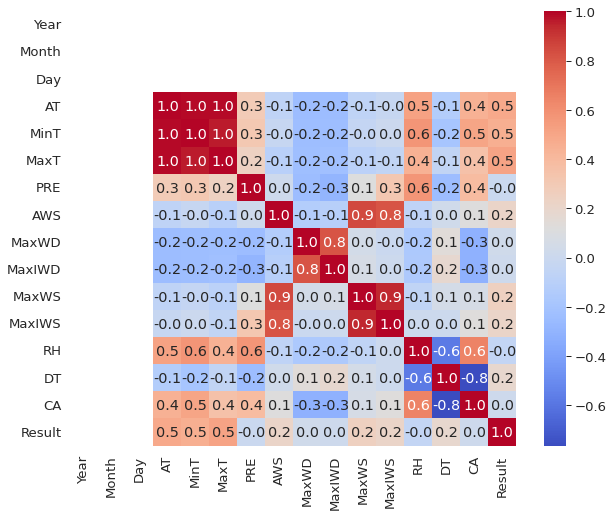

In [15]:
corr = df.corr()

sns.set_style('whitegrid')

sns.set_context('paper', font_scale=1.5)
plt.figure(figsize=(10, 8)) 
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt='.1f')


## Features Seletion

In [16]:
# Date New Columns
features = [
            'Year', 
            'Month',
            'Day',
            'AT', 
            'MinT', 
            'MaxT', 
            'PRE', 
            'AWS', 
            'MaxWD', 
            'MaxIWD', 
            'MaxWS',
            'MaxIWS', 
            'RH', 
            'DT', 
            'CA', 
           ]

## Split train test

In [17]:
train, test = train_test_split(df, test_size=0.3, random_state=42)

In [18]:
display(train.head(), test.head())

,Year,Month,Day,AT,MinT,MaxT,PRE,AWS,MaxWD,MaxIWD,MaxWS,MaxIWS,RH,DT,CA,Result
268,1970,1,1,20.0,14.8,25.4,NaN,1.7,12,12,3.5,5.3,58.5,7.8,6.5,0.0278
231,1970,1,1,28.2,25.7,32.0,NaN,2.4,13,13,4.4,8.1,80.0,9.6,4.8,0.0436
157,1970,1,1,20.6,15.1,25.1,NaN,2.7,3,4,5.2,10.0,54.5,6.2,6.4,0.0324
19,1970,1,1,-5.0,-9.8,0.9,NaN,1.8,15,15,4.7,7.0,63.5,9.1,0.0,0.0148
147,1970,1,1,22.3,15.0,29.3,NaN,2.8,11,10,6.8,12.4,54.1,12.4,2.1,0.0527


,Year,Month,Day,AT,MinT,MaxT,PRE,AWS,MaxWD,MaxIWD,MaxWS,MaxIWS,RH,DT,CA,Result
193,1970,1,1,25.0,24.0,27.1,114.5,1.8,7,6,3.9,8.6,93.9,NaN,10.0,0.0190
33,1970,1,1,-3.4,-6.9,0.4,NaN,2.4,13,13,4.6,8.2,52.4,9.7,1.5,0.0275
15,1970,1,1,-2.0,-7.2,2.4,NaN,3.2,12,12,5.7,9.4,54.5,8.8,1.6,0.0200
309,1970,1,1,9.6,3.7,16.4,NaN,1.8,9,14,3.3,5.5,60.5,9.6,2.6,0.0174
57,1970,1,1,3.7,-1.6,9.1,NaN,2.8,12,10,7.4,12.3,56.6,10.5,0.0,0.0320


In [19]:
target_variable = 'Result'

In [20]:
test_Result = test['Result']

In [21]:
test = test.drop(columns=[target_variable])

# Learning

In [22]:
X = train[features]
y = train[target_variable]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [23]:
model = CatBoostRegressor()

In [24]:
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=50)

Learning rate set to 0.038834
0:	learn: 0.0130372	test: 0.0115459	best: 0.0115459 (0)	total: 52.2ms	remaining: 52.1s
1:	learn: 0.0128242	test: 0.0113984	best: 0.0113984 (1)	total: 56ms	remaining: 27.9s
2:	learn: 0.0126649	test: 0.0112822	best: 0.0112822 (2)	total: 59ms	remaining: 19.6s
3:	learn: 0.0124607	test: 0.0111744	best: 0.0111744 (3)	total: 61.9ms	remaining: 15.4s
4:	learn: 0.0122773	test: 0.0110720	best: 0.0110720 (4)	total: 66.4ms	remaining: 13.2s
5:	learn: 0.0121043	test: 0.0109581	best: 0.0109581 (5)	total: 69.5ms	remaining: 11.5s
6:	learn: 0.0119196	test: 0.0108750	best: 0.0108750 (6)	total: 72.5ms	remaining: 10.3s
7:	learn: 0.0117262	test: 0.0107619	best: 0.0107619 (7)	total: 75.2ms	remaining: 9.33s
8:	learn: 0.0115643	test: 0.0106613	best: 0.0106613 (8)	total: 77.9ms	remaining: 8.57s
9:	learn: 0.0113867	test: 0.0105631	best: 0.0105631 (9)	total: 80.4ms	remaining: 7.96s
10:	learn: 0.0112091	test: 0.0104589	best: 0.0104589 (10)	total: 82.6ms	remaining: 7.43s
11:	learn: 0.01

# Predict

In [25]:
y_pred = model.predict(X_test)

In [26]:
y_pred

array([0.02979225, 0.03713552, 0.02228057, 0.02729303, 0.02555945,
       0.02474247, 0.03538658, 0.01962895, 0.03958737, 0.02183354,
       0.02905365, 0.03237675, 0.03581756, 0.02600975, 0.01418479,
       0.03306753, 0.01877165, 0.04103889, 0.03589618, 0.01326215,
       0.03514003, 0.03873765, 0.02503816, 0.02442308, 0.03889979,
       0.04913263, 0.03157954, 0.02795872, 0.02919238, 0.0280727 ,
       0.0314392 , 0.02346312, 0.02280695, 0.02905659, 0.03486625,
       0.03124622, 0.034479  , 0.04259305, 0.02261608, 0.02639447,
       0.03109462, 0.02337256, 0.01691307, 0.01716927, 0.02181414,
       0.02129598, 0.02835335, 0.03237424, 0.02880804, 0.02687563,
       0.02351489, 0.02870277, 0.03924978, 0.0202194 , 0.01417518,
       0.02606815, 0.04128192, 0.03880636, 0.04064376, 0.02730881,
       0.02154059, 0.01435991, 0.01305667, 0.03044349, 0.03291724,
       0.03113584, 0.03837895, 0.03199328, 0.03836112, 0.02904785,
       0.02161292, 0.0401446 , 0.01790148, 0.02881209, 0.03123

# Model Evaluation Metrics

### MSE

In [27]:
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)

Mean Squared Error (MSE): 7.230652237706163e-05


## Feature Importance

#### 1. Catboost importance

In [28]:
importances = model.get_feature_importance()
for feature, importance in zip(features, importances):
    print(f"{feature}: {importance}")

Year: 0.0
Month: 0.0
Day: 0.0
AT: 13.648726184040587
MinT: 11.802516806273855
MaxT: 15.47351444634554
PRE: 3.1911491890988537
AWS: 11.645466982385948
MaxWD: 8.42057430051354
MaxIWD: 4.829140651558934
MaxWS: 4.703185945083841
MaxIWS: 8.465808630161657
RH: 6.186942713183008
DT: 8.730518828695008
CA: 2.9024553226592236


#### 2. MI Score

In [29]:
X_mi = train[features]

X_mi.fillna(0, inplace=True)

/home/jayserver/docker_ozone/py36/lib/python3.6/site-packages/pandas/core/frame.py:4327: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [30]:
y_mi = train[target_variable]
mi_scores = mutual_info_regression(X_mi, y_mi)
mi_scores = pd.Series(mi_scores, name='MI Scores', index=X_mi.columns)
mi_scores = mi_scores.sort_values(ascending=False)
print(mi_scores)

AT        0.281747
MaxT      0.236587
MinT      0.177614
DT        0.082399
AWS       0.074903
MaxWD     0.055714
PRE       0.050515
MaxIWD    0.035683
MaxWS     0.033758
Month     0.000330
Day       0.000264
CA        0.000000
RH        0.000000
MaxIWS    0.000000
Year      0.000000
Name: MI Scores, dtype: float64


#### 3. RF

In [31]:
X_rf = train[features]

y_rf = train[target_variable]
X_rf.fillna(0, inplace=True)
rf = RandomForestRegressor(random_state=42)
rf.fit(X_rf, y_rf)

importances = pd.DataFrame({'Feature':X_rf.columns, 'Importance':rf.feature_importances_})
importances = importances.sort_values('Importance', ascending=False)

importances

/home/jayserver/docker_ozone/py36/lib/python3.6/site-packages/pandas/core/frame.py:4327: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


,Feature,Importance
3,AT,0.197076
5,MaxT,0.162794
12,RH,0.113007
13,DT,0.101775
4,MinT,0.084052
7,AWS,0.081058
11,MaxIWS,0.056162
10,MaxWS,0.054396
9,MaxIWD,0.049796
14,CA,0.043560


# Contrast



In [32]:
results = model.predict(test)

In [33]:
df_result1 = pd.DataFrame(test_Result)
df_result2 = pd.DataFrame(results)

In [34]:
matches = (np.array(df_result1['Result']) == np.array(df_result2[0])).sum()
accuracy = matches / len(df_result1)

print(accuracy)

0.0


In [35]:
diff = np.abs(np.array(df_result1['Result']) - np.array(df_result2[0]))
mean_absolute_difference = np.mean(diff)

print(mean_absolute_difference)

0.006605842390344288


# Optuna

In [36]:
def objective_catboost(trial):
    params = {
    'iterations': trial.suggest_int('iterations', 500, 3000),
    'learning_rate': trial.suggest_loguniform('learning_rate', 0.0001, 0.5),
    'depth': trial.suggest_int('depth', 4, 16),
    'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-6, 10),
    'random_strength': trial.suggest_loguniform('random_strength', 1e-6, 100),
    'bagging_temperature': trial.suggest_loguniform('bagging_temperature', 0.01, 10),
    'od_type': 'Iter',
    'od_wait': 50,
    'eval_metric': 'RMSE',
    'loss_function': 'RMSE',
    'verbose': False,
    'random_state': 42,
    'rsm': trial.suggest_uniform('rsm', 0.5, 1.0)
    }
    model = CatBoostRegressor(**params)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=50)

    y_pred = model.predict(X_test)
    return mean_squared_error(y_test, y_pred)

study_catboost = optuna.create_study(direction='minimize')
study_catboost.optimize(objective_catboost, n_trials=30)

print("CatBoost - Best trial:")
print(study_catboost.best_trial.params)
print("CatBoost - Best MSE:")
print(study_catboost.best_value)



[I 2023-07-16 21:54:21,263] A new study created in memory with name: no-name-f5b93ca0-44f5-452a-9dc3-b0af62b7bd31
/home/jayserver/docker_ozone/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/home/jayserver/docker_ozone/py36/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  
/home/jayserver/docker_ozone/py36/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/rele

[I 2023-07-16 21:55:30,062] Trial 4 finished with value: 7.751214396447231e-05 and parameters: {'iterations': 672, 'learning_rate': 0.007267116565015594, 'depth': 10, 'l2_leaf_reg': 2.5134175701858737e-06, 'random_strength': 7.023604786881552e-05, 'bagging_temperature': 3.9710282687957865, 'rsm': 0.6838852642615127}. Best is trial 4 with value: 7.751214396447231e-05.
/home/jayserver/docker_ozone/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/home/jayserver/docker_ozone/py36/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.sugg

/home/jayserver/docker_ozone/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/home/jayserver/docker_ozone/py36/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  
/home/jayserver/docker_ozone/py36/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  import sys
/home/jayserver/docker_ozone/

[I 2023-07-16 21:55:47,567] Trial 13 finished with value: 7.472352345653034e-05 and parameters: {'iterations': 1797, 'learning_rate': 0.05171718285522004, 'depth': 6, 'l2_leaf_reg': 0.19724512578796125, 'random_strength': 2.5615980695319804e-05, 'bagging_temperature': 0.45581099657728974, 'rsm': 0.8462527956447359}. Best is trial 12 with value: 7.436071080222257e-05.
/home/jayserver/docker_ozone/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/home/jayserver/docker_ozone/py36/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.sugg

/home/jayserver/docker_ozone/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/home/jayserver/docker_ozone/py36/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  
/home/jayserver/docker_ozone/py36/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  import sys
/home/jayserver/docker_ozone/

[I 2023-07-16 21:57:40,344] Trial 22 finished with value: 7.521517648756771e-05 and parameters: {'iterations': 1424, 'learning_rate': 0.07064873940308332, 'depth': 6, 'l2_leaf_reg': 1.5970623067076268, 'random_strength': 0.00024246709650651364, 'bagging_temperature': 0.6339745355800314, 'rsm': 0.8291698686526479}. Best is trial 18 with value: 7.355583114962693e-05.
/home/jayserver/docker_ozone/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/home/jayserver/docker_ozone/py36/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.sugges

/home/jayserver/docker_ozone/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/home/jayserver/docker_ozone/py36/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  
/home/jayserver/docker_ozone/py36/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  import sys
/home/jayserver/docker_ozone/

CatBoost - Best trial:
{'iterations': 2076, 'learning_rate': 0.10690272962775564, 'depth': 5, 'l2_leaf_reg': 1.3419234708184873, 'random_strength': 0.0009090743804495157, 'bagging_temperature': 2.673884975549106, 'rsm': 0.7929715501773235}
CatBoost - Best MSE:
7.355583114962693e-05


In [37]:
best_iterations = study_catboost.best_trial.params['iterations']
best_learning_rate = study_catboost.best_trial.params['learning_rate']
best_depth = study_catboost.best_trial.params['depth']
best_l2_leaf_reg = study_catboost.best_trial.params['l2_leaf_reg']
best_random_strength = study_catboost.best_trial.params['random_strength']
best_bagging_temperature = study_catboost.best_trial.params['bagging_temperature']
best_rsm = study_catboost.best_trial.params['rsm']

catboost = CatBoostRegressor(iterations=best_iterations,
                             learning_rate=best_learning_rate,
                             depth=best_depth, 
                             l2_leaf_reg=best_l2_leaf_reg,
                             random_strength=best_random_strength,
                             bagging_temperature=best_bagging_temperature,
                             rsm = best_rsm)

catboost.fit(X_train, y_train)

y_pred_catboost = catboost.predict(X_test)
mse_catboost = mean_squared_error(y_test, y_pred_catboost)
print("CatBoost - Test MSE:", mse_catboost)


0:	learn: 0.0124426	total: 2.36ms	remaining: 4.9s
1:	learn: 0.0117651	total: 5.18ms	remaining: 5.37s
2:	learn: 0.0111845	total: 7.26ms	remaining: 5.01s
3:	learn: 0.0106379	total: 9.7ms	remaining: 5.02s
4:	learn: 0.0101238	total: 12ms	remaining: 4.96s
5:	learn: 0.0096747	total: 14.4ms	remaining: 4.97s
6:	learn: 0.0092204	total: 16.9ms	remaining: 5s
7:	learn: 0.0088328	total: 18.7ms	remaining: 4.83s
8:	learn: 0.0084656	total: 20.8ms	remaining: 4.77s
9:	learn: 0.0081388	total: 22.8ms	remaining: 4.72s
10:	learn: 0.0078389	total: 24.7ms	remaining: 4.64s
11:	learn: 0.0075971	total: 26.5ms	remaining: 4.56s
12:	learn: 0.0073885	total: 28ms	remaining: 4.44s
13:	learn: 0.0071833	total: 30.4ms	remaining: 4.47s
14:	learn: 0.0069958	total: 33.1ms	remaining: 4.55s
15:	learn: 0.0067881	total: 35.3ms	remaining: 4.55s
16:	learn: 0.0066256	total: 37.4ms	remaining: 4.53s
17:	learn: 0.0064891	total: 39.5ms	remaining: 4.51s
18:	learn: 0.0062954	total: 41.9ms	remaining: 4.54s
19:	learn: 0.0061473	total: 44.

164:	learn: 0.0014682	total: 339ms	remaining: 3.93s
165:	learn: 0.0014611	total: 341ms	remaining: 3.92s
166:	learn: 0.0014472	total: 343ms	remaining: 3.92s
167:	learn: 0.0014360	total: 345ms	remaining: 3.91s
168:	learn: 0.0014194	total: 346ms	remaining: 3.91s
169:	learn: 0.0014013	total: 348ms	remaining: 3.9s
170:	learn: 0.0013948	total: 351ms	remaining: 3.9s
171:	learn: 0.0013827	total: 352ms	remaining: 3.9s
172:	learn: 0.0013656	total: 354ms	remaining: 3.9s
173:	learn: 0.0013535	total: 356ms	remaining: 3.89s
174:	learn: 0.0013425	total: 358ms	remaining: 3.89s
175:	learn: 0.0013282	total: 360ms	remaining: 3.89s
176:	learn: 0.0013174	total: 362ms	remaining: 3.88s
177:	learn: 0.0013049	total: 364ms	remaining: 3.88s
178:	learn: 0.0012927	total: 366ms	remaining: 3.87s
179:	learn: 0.0012777	total: 367ms	remaining: 3.87s
180:	learn: 0.0012660	total: 369ms	remaining: 3.86s
181:	learn: 0.0012581	total: 372ms	remaining: 3.87s
182:	learn: 0.0012550	total: 374ms	remaining: 3.87s
183:	learn: 0.00

354:	learn: 0.0003498	total: 713ms	remaining: 3.46s
355:	learn: 0.0003492	total: 715ms	remaining: 3.45s
356:	learn: 0.0003458	total: 717ms	remaining: 3.45s
357:	learn: 0.0003453	total: 719ms	remaining: 3.45s
358:	learn: 0.0003439	total: 721ms	remaining: 3.45s
359:	learn: 0.0003402	total: 724ms	remaining: 3.45s
360:	learn: 0.0003367	total: 727ms	remaining: 3.45s
361:	learn: 0.0003360	total: 729ms	remaining: 3.45s
362:	learn: 0.0003333	total: 732ms	remaining: 3.45s
363:	learn: 0.0003318	total: 734ms	remaining: 3.45s
364:	learn: 0.0003289	total: 737ms	remaining: 3.45s
365:	learn: 0.0003263	total: 739ms	remaining: 3.45s
366:	learn: 0.0003240	total: 741ms	remaining: 3.45s
367:	learn: 0.0003205	total: 743ms	remaining: 3.45s
368:	learn: 0.0003184	total: 745ms	remaining: 3.45s
369:	learn: 0.0003154	total: 748ms	remaining: 3.45s
370:	learn: 0.0003141	total: 749ms	remaining: 3.44s
371:	learn: 0.0003117	total: 752ms	remaining: 3.44s
372:	learn: 0.0003090	total: 754ms	remaining: 3.44s
373:	learn: 

551:	learn: 0.0000930	total: 1.08s	remaining: 3s
552:	learn: 0.0000926	total: 1.09s	remaining: 2.99s
553:	learn: 0.0000916	total: 1.09s	remaining: 2.99s
554:	learn: 0.0000913	total: 1.09s	remaining: 2.99s
555:	learn: 0.0000909	total: 1.09s	remaining: 2.99s
556:	learn: 0.0000900	total: 1.1s	remaining: 2.99s
557:	learn: 0.0000893	total: 1.1s	remaining: 2.99s
558:	learn: 0.0000888	total: 1.1s	remaining: 2.99s
559:	learn: 0.0000882	total: 1.1s	remaining: 2.99s
560:	learn: 0.0000873	total: 1.1s	remaining: 2.98s
561:	learn: 0.0000862	total: 1.11s	remaining: 2.98s
562:	learn: 0.0000850	total: 1.11s	remaining: 2.98s
563:	learn: 0.0000845	total: 1.11s	remaining: 2.98s
564:	learn: 0.0000842	total: 1.11s	remaining: 2.98s
565:	learn: 0.0000836	total: 1.12s	remaining: 2.98s
566:	learn: 0.0000828	total: 1.12s	remaining: 2.98s
567:	learn: 0.0000821	total: 1.12s	remaining: 2.98s
568:	learn: 0.0000819	total: 1.12s	remaining: 2.97s
569:	learn: 0.0000813	total: 1.12s	remaining: 2.97s
570:	learn: 0.000080

734:	learn: 0.0000256	total: 1.46s	remaining: 2.66s
735:	learn: 0.0000254	total: 1.46s	remaining: 2.65s
736:	learn: 0.0000252	total: 1.46s	remaining: 2.65s
737:	learn: 0.0000251	total: 1.46s	remaining: 2.65s
738:	learn: 0.0000249	total: 1.46s	remaining: 2.65s
739:	learn: 0.0000249	total: 1.47s	remaining: 2.65s
740:	learn: 0.0000248	total: 1.47s	remaining: 2.65s
741:	learn: 0.0000246	total: 1.47s	remaining: 2.64s
742:	learn: 0.0000245	total: 1.47s	remaining: 2.64s
743:	learn: 0.0000242	total: 1.47s	remaining: 2.64s
744:	learn: 0.0000240	total: 1.48s	remaining: 2.64s
745:	learn: 0.0000238	total: 1.48s	remaining: 2.63s
746:	learn: 0.0000235	total: 1.48s	remaining: 2.63s
747:	learn: 0.0000235	total: 1.48s	remaining: 2.63s
748:	learn: 0.0000234	total: 1.48s	remaining: 2.63s
749:	learn: 0.0000232	total: 1.48s	remaining: 2.62s
750:	learn: 0.0000231	total: 1.49s	remaining: 2.62s
751:	learn: 0.0000229	total: 1.49s	remaining: 2.62s
752:	learn: 0.0000228	total: 1.49s	remaining: 2.62s
753:	learn: 

937:	learn: 0.0000066	total: 1.83s	remaining: 2.22s
938:	learn: 0.0000066	total: 1.83s	remaining: 2.22s
939:	learn: 0.0000065	total: 1.83s	remaining: 2.21s
940:	learn: 0.0000065	total: 1.83s	remaining: 2.21s
941:	learn: 0.0000064	total: 1.84s	remaining: 2.21s
942:	learn: 0.0000064	total: 1.84s	remaining: 2.21s
943:	learn: 0.0000063	total: 1.84s	remaining: 2.21s
944:	learn: 0.0000063	total: 1.84s	remaining: 2.2s
945:	learn: 0.0000062	total: 1.84s	remaining: 2.2s
946:	learn: 0.0000062	total: 1.84s	remaining: 2.2s
947:	learn: 0.0000062	total: 1.85s	remaining: 2.2s
948:	learn: 0.0000061	total: 1.85s	remaining: 2.19s
949:	learn: 0.0000061	total: 1.85s	remaining: 2.19s
950:	learn: 0.0000060	total: 1.85s	remaining: 2.19s
951:	learn: 0.0000060	total: 1.85s	remaining: 2.19s
952:	learn: 0.0000060	total: 1.85s	remaining: 2.19s
953:	learn: 0.0000059	total: 1.86s	remaining: 2.18s
954:	learn: 0.0000059	total: 1.86s	remaining: 2.18s
955:	learn: 0.0000058	total: 1.86s	remaining: 2.18s
956:	learn: 0.00

1146:	learn: 0.0000018	total: 2.19s	remaining: 1.78s
1147:	learn: 0.0000017	total: 2.2s	remaining: 1.78s
1148:	learn: 0.0000017	total: 2.2s	remaining: 1.77s
1149:	learn: 0.0000017	total: 2.2s	remaining: 1.77s
1150:	learn: 0.0000017	total: 2.2s	remaining: 1.77s
1151:	learn: 0.0000017	total: 2.21s	remaining: 1.77s
1152:	learn: 0.0000017	total: 2.21s	remaining: 1.77s
1153:	learn: 0.0000016	total: 2.21s	remaining: 1.77s
1154:	learn: 0.0000016	total: 2.21s	remaining: 1.76s
1155:	learn: 0.0000016	total: 2.21s	remaining: 1.76s
1156:	learn: 0.0000016	total: 2.22s	remaining: 1.76s
1157:	learn: 0.0000016	total: 2.22s	remaining: 1.76s
1158:	learn: 0.0000016	total: 2.22s	remaining: 1.76s
1159:	learn: 0.0000016	total: 2.23s	remaining: 1.76s
1160:	learn: 0.0000016	total: 2.23s	remaining: 1.75s
1161:	learn: 0.0000015	total: 2.23s	remaining: 1.75s
1162:	learn: 0.0000015	total: 2.23s	remaining: 1.75s
1163:	learn: 0.0000015	total: 2.23s	remaining: 1.75s
1164:	learn: 0.0000015	total: 2.24s	remaining: 1.7

1343:	learn: 0.0000005	total: 2.57s	remaining: 1.4s
1344:	learn: 0.0000005	total: 2.57s	remaining: 1.4s
1345:	learn: 0.0000005	total: 2.57s	remaining: 1.39s
1346:	learn: 0.0000005	total: 2.57s	remaining: 1.39s
1347:	learn: 0.0000005	total: 2.58s	remaining: 1.39s
1348:	learn: 0.0000005	total: 2.58s	remaining: 1.39s
1349:	learn: 0.0000005	total: 2.58s	remaining: 1.39s
1350:	learn: 0.0000005	total: 2.58s	remaining: 1.38s
1351:	learn: 0.0000005	total: 2.58s	remaining: 1.38s
1352:	learn: 0.0000005	total: 2.58s	remaining: 1.38s
1353:	learn: 0.0000004	total: 2.58s	remaining: 1.38s
1354:	learn: 0.0000004	total: 2.59s	remaining: 1.38s
1355:	learn: 0.0000004	total: 2.59s	remaining: 1.37s
1356:	learn: 0.0000004	total: 2.59s	remaining: 1.37s
1357:	learn: 0.0000004	total: 2.59s	remaining: 1.37s
1358:	learn: 0.0000004	total: 2.59s	remaining: 1.37s
1359:	learn: 0.0000004	total: 2.6s	remaining: 1.37s
1360:	learn: 0.0000004	total: 2.6s	remaining: 1.36s
1361:	learn: 0.0000004	total: 2.6s	remaining: 1.36

1534:	learn: 0.0000001	total: 2.94s	remaining: 1.03s
1535:	learn: 0.0000001	total: 2.94s	remaining: 1.03s
1536:	learn: 0.0000001	total: 2.94s	remaining: 1.03s
1537:	learn: 0.0000001	total: 2.94s	remaining: 1.03s
1538:	learn: 0.0000001	total: 2.94s	remaining: 1.03s
1539:	learn: 0.0000001	total: 2.95s	remaining: 1.02s
1540:	learn: 0.0000001	total: 2.95s	remaining: 1.02s
1541:	learn: 0.0000001	total: 2.95s	remaining: 1.02s
1542:	learn: 0.0000001	total: 2.95s	remaining: 1.02s
1543:	learn: 0.0000001	total: 2.95s	remaining: 1.02s
1544:	learn: 0.0000001	total: 2.96s	remaining: 1.01s
1545:	learn: 0.0000001	total: 2.96s	remaining: 1.01s
1546:	learn: 0.0000001	total: 2.96s	remaining: 1.01s
1547:	learn: 0.0000001	total: 2.96s	remaining: 1.01s
1548:	learn: 0.0000001	total: 2.96s	remaining: 1.01s
1549:	learn: 0.0000001	total: 2.96s	remaining: 1.01s
1550:	learn: 0.0000001	total: 2.97s	remaining: 1s
1551:	learn: 0.0000001	total: 2.97s	remaining: 1s
1552:	learn: 0.0000001	total: 2.97s	remaining: 1s
15

1739:	learn: 0.0000000	total: 3.3s	remaining: 638ms
1740:	learn: 0.0000000	total: 3.31s	remaining: 636ms
1741:	learn: 0.0000000	total: 3.31s	remaining: 634ms
1742:	learn: 0.0000000	total: 3.31s	remaining: 632ms
1743:	learn: 0.0000000	total: 3.31s	remaining: 630ms
1744:	learn: 0.0000000	total: 3.31s	remaining: 628ms
1745:	learn: 0.0000000	total: 3.31s	remaining: 627ms
1746:	learn: 0.0000000	total: 3.32s	remaining: 625ms
1747:	learn: 0.0000000	total: 3.32s	remaining: 623ms
1748:	learn: 0.0000000	total: 3.32s	remaining: 621ms
1749:	learn: 0.0000000	total: 3.32s	remaining: 619ms
1750:	learn: 0.0000000	total: 3.32s	remaining: 617ms
1751:	learn: 0.0000000	total: 3.33s	remaining: 615ms
1752:	learn: 0.0000000	total: 3.33s	remaining: 613ms
1753:	learn: 0.0000000	total: 3.33s	remaining: 611ms
1754:	learn: 0.0000000	total: 3.33s	remaining: 609ms
1755:	learn: 0.0000000	total: 3.33s	remaining: 608ms
1756:	learn: 0.0000000	total: 3.34s	remaining: 606ms
1757:	learn: 0.0000000	total: 3.34s	remaining: 

1945:	learn: 0.0000000	total: 3.68s	remaining: 246ms
1946:	learn: 0.0000000	total: 3.68s	remaining: 244ms
1947:	learn: 0.0000000	total: 3.68s	remaining: 242ms
1948:	learn: 0.0000000	total: 3.68s	remaining: 240ms
1949:	learn: 0.0000000	total: 3.68s	remaining: 238ms
1950:	learn: 0.0000000	total: 3.69s	remaining: 236ms
1951:	learn: 0.0000000	total: 3.69s	remaining: 234ms
1952:	learn: 0.0000000	total: 3.69s	remaining: 232ms
1953:	learn: 0.0000000	total: 3.69s	remaining: 230ms
1954:	learn: 0.0000000	total: 3.69s	remaining: 229ms
1955:	learn: 0.0000000	total: 3.69s	remaining: 227ms
1956:	learn: 0.0000000	total: 3.7s	remaining: 225ms
1957:	learn: 0.0000000	total: 3.7s	remaining: 223ms
1958:	learn: 0.0000000	total: 3.7s	remaining: 221ms
1959:	learn: 0.0000000	total: 3.7s	remaining: 219ms
1960:	learn: 0.0000000	total: 3.7s	remaining: 217ms
1961:	learn: 0.0000000	total: 3.71s	remaining: 215ms
1962:	learn: 0.0000000	total: 3.71s	remaining: 213ms
1963:	learn: 0.0000000	total: 3.71s	remaining: 212m